Notebook to illustrate the functions and utilities present in basic_functions.py

In [1]:
from basic_functions import *

Make a z luminosity distance array that can be easily interpolated

In [2]:
z_array = np.linspace(0.0001,10.,100)
luminosity_distance_array = luminosity_distance(z_array, 70.5, 0.3)
cosmo_true_z_luminosity_distance_list = np.array([z_array, luminosity_distance_array])

Define parameters for a waveform

In [3]:
m1 = 1.2
m2 = 1.4
z = 3
theta = 1
effective_distance = np.interp(z, cosmo_true_z_luminosity_distance_list[0], cosmo_true_z_luminosity_distance_list[1])/theta
q = q_from_m1_m2(m1,m2)
lambda_tilde = lambda_tilde_from_m1_m2(m1,m2)
m_chirp = m_chirp_from_m1_m2(m1,m2)
m_chirp_z = m_chirp * (1+z)
    
keys = ['m_chirp_z', 'q', 'lambda_tilde', 'effective_distance', 'z']
values = [m_chirp_z, q, lambda_tilde, effective_distance, z]
pars = dict(zip(keys, values))

Define the detector PSD

In [4]:
freq, psd = np.loadtxt('CE_psd.txt', unpack=True)

Plot the waveform

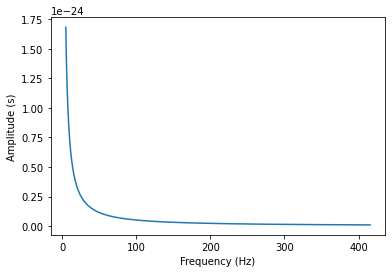

In [5]:
waveform = Waveform(pars, freq)
waveform.plot_waveform()

Calcultae the SNR. For this code SNR less than 10 may create problems.

In [8]:
print(waveform.snr(psd))

18.029809359571082


Plot log q, log lambda tilde, log luminosity distance samples

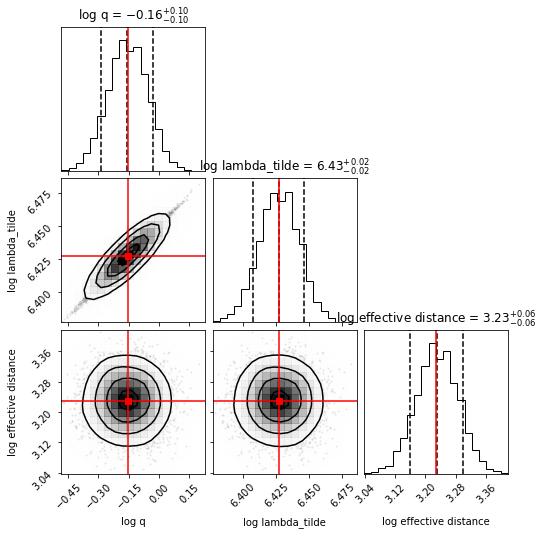

In [9]:
waveform.calculate_errors(psd)
waveform.make_log_q_log_lambda_tilde_samples()
waveform.plot_log_q_log_lambda_tilde_log_effective_distance_samples()


We make a grid of chirp mass, using log lambda tilde and log q as the axis and save it in a .txt file for reference

In [ ]:
log_q_array = np.linspace(np.log(0.3),np.log(3),50)
log_lambda_tilde_array = np.linspace(4,10,50)
m_chirp_grid = m_chirp_grid_from_log_q_log_lambda_tilde(log_q_array,log_lambda_tilde_array)
np.savetxt('m_chirp_grid_using_SLY.txt', m_chirp_grid)


Make a imshow of chirp mass grid

Text(0, 0.5, 'log(lambda_tilde)')

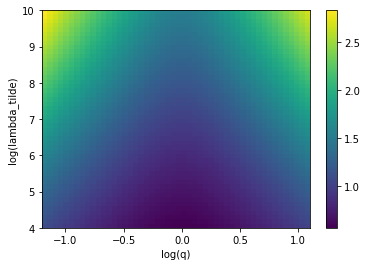

In [14]:
plt.imshow(m_chirp_grid, extent=[np.log(0.3),np.log(3),4,10], aspect='auto')
plt.colorbar()
plt.xlabel('log(q)')
plt.ylabel('log(lambda_tilde)')

Now we look at chirp mass, log q and redshift samples

1.1276930384897605


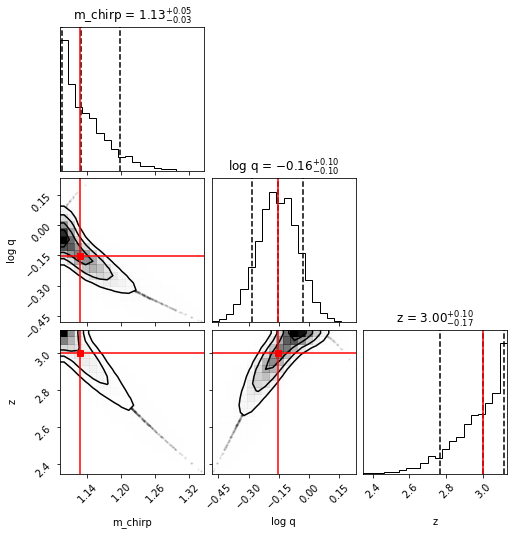

In [12]:
log_q_array = np.linspace(np.log(0.3),np.log(3),50)
log_lambda_tilde_array = np.linspace(4,10,50)
m_chirp_grid = np.loadtxt('m_chirp_grid_using_SLY.txt')#m_chirp_grid_from_q_log_lambda_tilde(q_array,log_lambda_tilde_array)
waveform.make_z_m_chirp_samples(m_chirp_grid, log_q_array, log_lambda_tilde_array)
waveform.plot_m_chirp_log_q_z()

Lets make a population of 500 optimally aligned events

In [27]:
n_events = 1024
m_chirp_population = np.random.uniform(1, 1.4, n_events)
q_population = np.random.uniform(0.7, 0.95, n_events)
lambda_tilde_population = lambda_tilde_from_m_chirp_q(m_chirp_population, q_population)
z_population = np.random.beta(3,9,n_events)*10
theta_population = np.ones(n_events)
effective_distance_population = np.interp(z_population, cosmo_true_z_luminosity_distance_list[0], cosmo_true_z_luminosity_distance_list[1])/theta_population
m_chirp_z_population = m_chirp_population * (1+z_population)


Study the SNR distribution of events

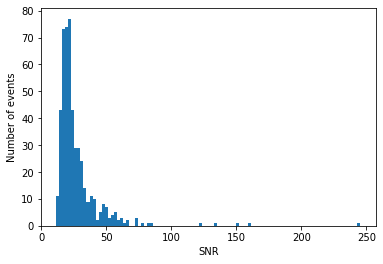

11.192027794233327


In [19]:
snr_population = np.zeros(n_events)
for n_events_ in range(n_events):
    pars_ = dict(zip(keys, [m_chirp_z_population[n_events_], q_population[n_events_], lambda_tilde_population[n_events_], effective_distance_population[n_events_], z_population[n_events_]]))
    waveform_ = Waveform(pars_, freq)
    snr_population[n_events_]  = waveform_.snr(psd)

#Make a histogram of the SNR values
plt.hist(snr_population, bins=100)
plt.xlabel('SNR')
plt.ylabel('Number of events')
plt.show()
print (np.min(snr_population))

    

We make an array of measured redshift, errors on log effective distance  

In [42]:
redshift_measured = np.zeros(n_events)
log_effective_distance_error = np.zeros(n_events)
for n_events_ in range(n_events):
    pars_ = dict(zip(keys, [m_chirp_z_population[n_events_], q_population[n_events_], lambda_tilde_population[n_events_], effective_distance_population[n_events_], z_population[n_events_]]))
    waveform_ = Waveform(pars_, freq)
    waveform_.calculate_errors(psd)
    waveform_.make_log_q_log_lambda_tilde_samples()
    waveform_.make_z_m_chirp_samples(m_chirp_grid, log_q_array, log_lambda_tilde_array)
    redshift_measured[n_events_] = np.median(waveform_.z_samples)
    log_effective_distance_error[n_events_] = waveform_.log_effective_distance_error
  

Plot how many sigmas the effective distance due to the measured redshift are off frue the true effective distance 

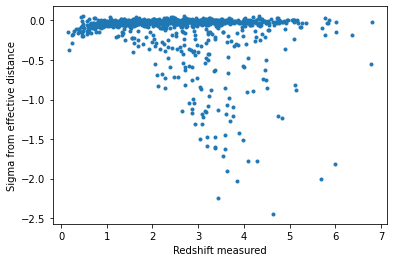

In [43]:
effective_distance_from_redshift_measured = np.interp(redshift_measured, cosmo_true_z_luminosity_distance_list[0], cosmo_true_z_luminosity_distance_list[1])
sigma_from_effective_distance = (effective_distance_from_redshift_measured - effective_distance_population)/(log_effective_distance_error * effective_distance_population)
#Plot the redshift population vs sigma from effective distance
plt.plot(redshift_measured, sigma_from_effective_distance, '.')
plt.xlabel('Redshift measured')
plt.ylabel('Sigma from effective distance')
plt.show()




Plot redshift measured vs log eddective distance population

[70.646717    0.29145357] [[ 2.42544233e-03 -4.62287248e-05]
 [-4.62287248e-05  1.12204856e-06]]


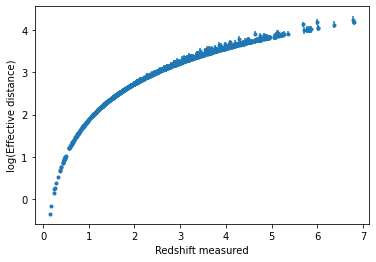

In [44]:
from scipy.optimize import curve_fit
plt.errorbar(redshift_measured, np.log(effective_distance_population), yerr=log_effective_distance_error, fmt='.')
plt.xlabel('Redshift measured')
plt.ylabel('log(Effective distance)')
#fit using scipy.optimize.curve_fit
def func(z, H_0, Omega_m):
    z_array = np.linspace(0.0001,10.,100)
    luminosity_distance_array = luminosity_distance(z_array, H_0, Omega_m)
    cosmo_true_z_luminosity_distance_list = np.array([z_array, luminosity_distance_array])
    return np.log(np.interp(z, cosmo_true_z_luminosity_distance_list[0], cosmo_true_z_luminosity_distance_list[1]))
    
popt, pcov = curve_fit(func, redshift_measured, np.log(effective_distance_population), sigma=log_effective_distance_error)
print (popt, pcov)